# Extraction of Sub-Mechanisms

Code is ported (almost) verbatim from cantera example file `extract_submechanism.py` (distributed with cantera):
```
"""
An example demonstrating how to use Species and Reaction objects to
programmatically extract a reaction submechanism. In this example, the CO/H2
oxidation reactions are extracted from the GRI 3.0 mechanism.

To test the submechanism, a premixed CO/H2 flame is simulated using the original
mechanism and the submechanism, which demonstrates that the submechanism
contains all of the important species and reactions.
"""
```

In [6]:
from timeit import default_timer
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [3]:
all_species = ct.Species.listFromFile('gri30.xml')
species = []

# Filter species
for S in all_species:
    comp = S.composition
    if 'C' in comp and 'H' in comp:
        # Exclude all hydrocarbon species
        continue
    if 'N' in comp and comp != {'N':2}:
        # Exclude all nitrogen compounds except for N2
        continue
    if 'Ar' in comp:
        # Exclude Argon
        continue

    species.append(S)

species_names = {S.name for S in species}
print('Species: {0}'.format(', '.join(S.name for S in species)))

Species: H2, H, O, O2, OH, H2O, HO2, H2O2, C, CO, CO2, N2


In [4]:
# Filter reactions, keeping only those that only involve the selected species
all_reactions = ct.Reaction.listFromFile('gri30.xml')
reactions = []

print('\nReactions:')
for R in all_reactions:
    if not all(reactant in species_names for reactant in R.reactants):
        continue

    if not all(product in species_names for product in R.products):
        continue

    reactions.append(R)
    print(R.equation)
print('\n')


Reactions:
2 O + M <=> O2 + M
H + O + M <=> OH + M
H2 + O <=> H + OH
HO2 + O <=> O2 + OH
H2O2 + O <=> HO2 + OH
CO + O (+M) <=> CO2 (+M)
CO + O2 <=> CO2 + O
H + O2 + M <=> HO2 + M
H + 2 O2 <=> HO2 + O2
H + H2O + O2 <=> H2O + HO2
H + N2 + O2 <=> HO2 + N2
H + O2 <=> O + OH
2 H + M <=> H2 + M
2 H + H2 <=> 2 H2
2 H + H2O <=> H2 + H2O
CO2 + 2 H <=> CO2 + H2
H + OH + M <=> H2O + M
H + HO2 <=> H2O + O
H + HO2 <=> H2 + O2
H + HO2 <=> 2 OH
H + H2O2 <=> H2 + HO2
H + H2O2 <=> H2O + OH
H2 + OH <=> H + H2O
2 OH (+M) <=> H2O2 (+M)
2 OH <=> H2O + O
HO2 + OH <=> H2O + O2
H2O2 + OH <=> H2O + HO2
H2O2 + OH <=> H2O + HO2
C + OH <=> CO + H
CO + OH <=> CO2 + H
2 HO2 <=> H2O2 + O2
2 HO2 <=> H2O2 + O2
CO + HO2 <=> CO2 + OH
C + O2 <=> CO + O
HO2 + OH <=> H2O + O2




In [5]:
gas1 = ct.Solution('gri30.xml')
gas2 = ct.Solution(thermo='IdealGas', kinetics='GasKinetics',
                   species=species, reactions=reactions)

def solve_flame(gas):
    gas.TPX = 373, 0.05*ct.one_atm, 'H2:0.4, CO:0.6, O2:1, N2:3.76'

    # Create the flame simulation object
    sim = ct.CounterflowPremixedFlame(gas=gas, width=0.2)

    sim.reactants.mdot = 0.12 # kg/m^2/s
    sim.products.mdot = 0.06 # kg/m^2/s

    sim.set_refine_criteria(ratio=3, slope=0.1, curve=0.2)
    sim.solve(0, auto=True)
    return sim

t1 = default_timer()
sim1 = solve_flame(gas1)
t2 = default_timer()
print('Solved with GRI 3.0 in {0:.2f} seconds'.format(t2-t1))
sim2 = solve_flame(gas2)
t3 = default_timer()
print('Solved with CO/H2 submechanism in {0:.2f} seconds'.format(t3-t2))

Solved with GRI 3.0 in 11.45 seconds
Solved with CO/H2 submechanism in 0.42 seconds


<IPython.core.display.Javascript object>


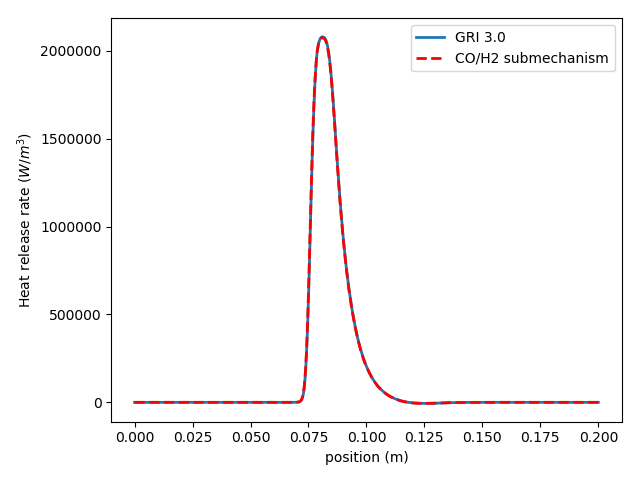

In [7]:
plt.plot(sim1.grid, sim1.heat_release_rate,
         lw=2, label='GRI 3.0')

plt.plot(sim2.grid, sim2.heat_release_rate,
         'r--', lw=2, label='CO/H2 submechanism')

plt.ylabel('Heat release rate ($W/m^3$)')
plt.xlabel('position (m)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()